# [실습3] 딥러닝을 활용한 기계설비 예지보전 과정 이해 (정답)
----

## 실습 목차
---
1. 주식 데이터를 이용한 가격 예측
2. 분류 모델 적용을 위한 모터 센서 시계열 데이터셋 변환
3. tensorflow를 활용한 RNN 기반 모델을 모터 데이터에 적용
4. 기존 분류 알고리즘과의 성능 비교하기

## 실습 개요
---
딥러닝에 대한 이해 및 RNN 모델을 활용한 복잡한 데이터 학습 과정 이해하고 기계설비 이상 여부 진단 데이터 및 RNN 계열 인공지능 모델을 활용한 생산설비 예지보전과정에 대해 이해합니다.

---

## 라이브러리 불러오기

- **pandas**: 데이터프레임을 다루기 위한 라이브러리
- **sklearn**: 머신러닝을 다루기 위한 라이브러리
- **tensorflow**: 딥러닝 학습을 위한 Tensor을 다루기 위한 라이브러리
- **tensorflow.kears**: 사용자 친화적인 keras의 API를 사용하여 tensorflow를 다루기 위한 라이브러리

In [2]:
import FinanceDataReader as fdr    # 국내 주식 정보 api 라이브러리
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras import Sequential, layers, callbacks, backend

2023-08-22 06:07:59.047975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 06:08:02.170292: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-22 06:08:21.752508: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-22 06:08:21.753371: W tensorflow/

## 1. 주식 데이터를 이용한 가격 예측

---

주식 데이터는 시계열 데이터 중 가장 대표적인 데이터 입니다. 오늘 우리가 모터 센서 시계열 데이터에 대한 예측 모델을 만들기 전 연습을 위해 주식 데이터를 이용한 가격 예측을 진행합니다. 

시계열 데이터: 일정한 시간 간격으로 기록된 데이터를 의미합니다. 이러한 데이터는 일련의 순서대로 발생한 이벤트나 측정값을 포함하며, 시간에 따른 패턴, 동향, 주기성 등을 분석하고 예측하는 데 사용됩니다.

시계열 데이터의 특징

- 순서: 시계열 데이터는 시간 순서대로 기록되는 데이터로, 과거부터 현재까지의 순서가 중요합니다.
- 시간 간격: 시간 간격은 데이터 포인트 사이의 시간 간격을 의미하며, 규칙적이거나 불규칙할 수 있습니다.
- 시간에 따른 패턴: 시계열 데이터는 시간에 따른 특정한 패턴, 동향, 주기성을 가질 수 있습니다. 이를 분석하여 추세, 계절성, 주기 등을 파악할 수 있습니다.
- 시간 의존성: 시계열 데이터는 과거 데이터가 현재와 미래의 데이터에 영향을 줄 수 있으며, 이전 값이 다음 값을 예측하는 데 도움이 될 수 있습니다.
- 시계열 분해: 시계열 데이터는 전체적으로 추세, 계절성, 불규칙 요소로 분해할 수 있습니다. 이를 통해 데이터의 구성 요소를 분리하고 이해할 수 있습니다.


**FinanceDataReader 상세 설명**

한국 주식 가격, 미국주식 가격, 지수, 환율, 암호화폐 가격, 종목 리스팅 등 금융 데이터 수집 라이브러리

pandas-datareader 는 잘 구성된 시계열 데이터 수집 라이브러리로 사용이 간편하고 다양한 시계열 데이터를 수집할 수 있다는 장점이 있다. (현재 버전 : pandas_datareader 0.6.0) 하지만, 거래소별(KRX, NASDAQ, NYSE 등) 전체 종목 코드(ticker symbol)를 가져오는 기능이 없으며, 야후 파이낸스가 더 이상지원되지 않고(deprecated), 구글 파이낸스는 UNSTABLE_WARNING + RemoteDataError 를 낸다.

FinanceDataReader는 pandas-datareader 를 대체하기 보다 보완하기 위한 목적으로 만들어졌다. 주요한 기능은 다음과 같다.

종목 코드
- 거래소별 전체 종목코드: KRX (KOSPI, KODAQ, KONEX), NASDAQ, NYSE, AMEX, S&P 500
가격 데이터
- 해외주식 가격 데이터: AAPL(애플), AMZN(아마존), GOOG(구글) 등
- 국내주식 가격 데이터: 005920(삼성전자), 091990(셀트리온헬스케어) 등
- 각종 지수: KS11(코스피지수), KQ11(코스닥지수), DJI(다우지수), IXIC(나스닥 지수), US500(S&P 5000)
- 환율 데이터: USD/KRX (원달러 환율), USD/EUR(달러당 유로화 환율), CNY/KRW: 위엔화 원화 환율
- 암호화폐 가격: BTC/USD (비트코인 달러 가격, Bitfinex), BTC/KRW (비트코인 원화 가격, 빗썸)


삼성전자 주식 데이터를 가져와 `df`에 저장합니다.

In [3]:
df = fdr.DataReader("005930", start = '1999').reset_index().fillna(0)
df = df[df.Open != 0]
df

,Date,Open,High,Low,Close,Volume,Change
0,1999-05-12,1819,1827,1745,1810,942356,0.000000
1,1999-05-13,1840,1850,1794,1798,580832,-0.006630
2,1999-05-14,1830,1930,1820,1880,816407,0.045606
3,1999-05-17,1840,1860,1808,1808,579474,-0.038298
4,1999-05-18,1821,1858,1805,1830,359949,0.012168
...,...,...,...,...,...,...,...
5995,2023-08-16,66700,67100,66300,67000,13174578,-0.004458
5996,2023-08-17,66300,66800,66000,66700,10778652,-0.004478
5997,2023-08-18,66000,66700,65800,66300,11745006,-0.005997
5998,2023-08-21,66600,67100,66300,66600,9720067,0.004525


In [4]:
df[df.Open==0]

,Date,Open,High,Low,Close,Volume,Change


`df`의 통계치를 확인합니다.

In [5]:
df.describe()

,Open,High,Low,Close,Volume,Change
count,5997.000000,5997.000000,5997.000000,5997.000000,5.997000e+03,5997.000000
mean,26556.736035,26822.004169,26282.380524,26548.586293,3.787321e+06,0.000860
std,21434.687441,21603.291597,21250.360746,21415.693971,7.274283e+06,0.022851
min,1606.000000,1668.000000,1578.000000,1626.000000,6.598500e+04,-0.137566
25%,10200.000000,10340.000000,10040.000000,10200.000000,2.944110e+05,-0.011222
50%,18000.000000,18240.000000,17760.000000,18000.000000,5.023210e+05,0.000000
75%,42600.000000,43000.000000,42150.000000,42560.000000,1.216380e+06,0.012000
max,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07,0.150000


In [6]:
df[df['High'] == df['High'].max()]

,Date,Open,High,Low,Close,Volume,Change
5352,2021-01-11,90000,96800,89500,91000,90306177,0.024775


`df`의 종가를 시각화 합니다.

<Axes: >

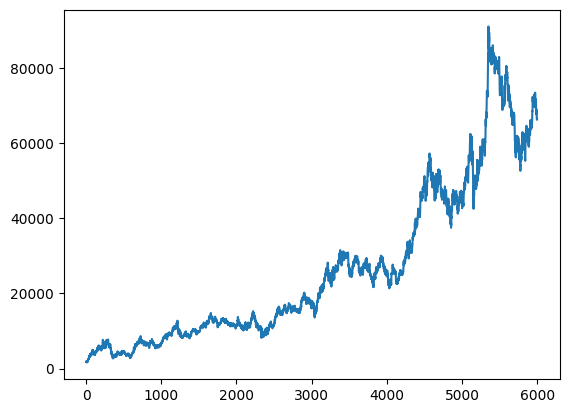

In [7]:
df.Close.plot()

`df`의 변화율을 시각화 합니다.

<Axes: >

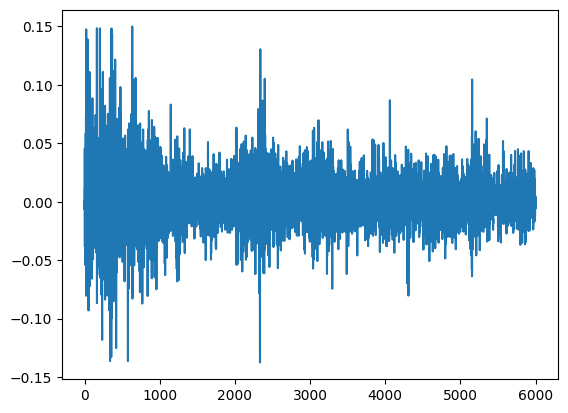

In [8]:
df.Change.plot()

`df`의 `Open`, `High`, `Low`, `Close`, `Volume` 컬럼에 MinMaxScaler()를 적용합니다.

In [12]:
scale_cols

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [11]:
scaler = MinMaxScaler()

scale_cols = df.columns[1:-1]
df_scaled = scaler.fit_transform(df[scale_cols])
df[scale_cols] = pd.DataFrame(df_scaled)

In [13]:
df

,Date,Open,High,Low,Close,Volume,Change
0,1999-05-12,0.002402,0.001671,0.001899,0.002059,0.009712,0.000000
1,1999-05-13,0.002638,0.001913,0.002457,0.001924,0.005705,-0.006630
2,1999-05-14,0.002526,0.002754,0.002752,0.002842,0.008316,0.045606
3,1999-05-17,0.002638,0.002018,0.002616,0.002036,0.005690,-0.038298
4,1999-05-18,0.002424,0.001997,0.002582,0.002283,0.003258,0.012168
...,...,...,...,...,...,...,...
5995,2023-08-16,0.732789,0.687802,0.736130,0.726990,0.106982,-0.004458
5996,2023-08-17,0.739554,0.694109,0.736130,0.723633,0.095386,-0.004478
5997,2023-08-18,NaN,NaN,NaN,NaN,NaN,-0.005997
5998,2023-08-21,NaN,NaN,NaN,NaN,NaN,0.004525


실제 예측에 사용할 데이터를 분할하여 `test_df`에 저장합니다.

In [14]:
window_size = 20
test_df = df.tail(window_size)
test_df

,Date,Open,High,Low,Close,Volume,Change
5980,2023-07-25,0.791418,0.743514,0.779350,0.771746,0.214480,-0.005682
5981,2023-07-26,0.781270,0.728798,0.775938,0.762795,0.143721,-0.002857
5982,2023-07-27,0.772251,0.730900,0.778213,0.777340,0.135563,0.027221
5983,2023-07-28,0.779015,0.728798,0.775938,0.763913,0.152582,-0.015342
5984,2023-07-31,0.769996,0.720389,0.761152,0.751606,0.221865,-0.011331
5985,2023-08-01,0.757594,0.708826,0.757740,0.746011,0.136239,0.018625
5986,2023-08-02,0.745191,0.709877,0.750916,0.748249,0.120817,-0.016878
5987,2023-08-03,0.759848,0.708826,0.748641,0.738179,0.161776,-0.015737
5988,2023-08-04,0.748574,0.714081,0.754328,0.752725,0.190532,-0.007267
5989,2023-08-07,0.751956,0.702519,0.753190,0.742654,0.112603,0.002928


실제 예측에 사용할 데이터를 제외 한 데이터를 `df`에 저장합니다.


In [15]:
df = df.iloc[:-window_size]
df

,Date,Open,High,Low,Close,Volume,Change
0,1999-05-12,0.002402,0.001671,0.001899,0.002059,0.009712,0.000000
1,1999-05-13,0.002638,0.001913,0.002457,0.001924,0.005705,-0.006630
2,1999-05-14,0.002526,0.002754,0.002752,0.002842,0.008316,0.045606
3,1999-05-17,0.002638,0.002018,0.002616,0.002036,0.005690,-0.038298
4,1999-05-18,0.002424,0.001997,0.002582,0.002283,0.003258,0.012168
...,...,...,...,...,...,...,...
5975,2023-07-18,0.775633,0.722491,0.771388,0.768389,0.182435,-0.017735
5976,2023-07-19,0.772251,0.727747,0.777075,0.769508,0.147967,-0.004167
5977,2023-07-20,0.771123,0.723542,0.775938,0.765032,0.157900,-0.009763
5978,2023-07-21,0.768868,0.724593,0.756602,0.762795,0.331895,-0.009859


In [32]:
df[18:]

,Date,Open,High,Low,Close,Volume,Change
18,1999-06-07,0.003991,0.003910,0.004072,0.004632,0.012076,0.073684
19,1999-06-08,0.004893,0.004015,0.004368,0.004073,0.009874,-0.024510
20,1999-06-09,0.003766,0.003069,0.002855,0.002283,0.007322,-0.080402
21,1999-06-10,0.002954,0.004541,0.003230,0.005304,0.022403,0.147541
22,1999-06-11,0.005570,0.006749,0.005368,0.006199,0.021092,0.038095
...,...,...,...,...,...,...,...
5975,2023-07-18,0.775633,0.722491,0.771388,0.768389,0.182435,-0.017735
5976,2023-07-19,0.772251,0.727747,0.777075,0.769508,0.147967,-0.004167
5977,2023-07-20,0.771123,0.723542,0.775938,0.765032,0.157900,-0.009763
5978,2023-07-21,0.768868,0.724593,0.756602,0.762795,0.331895,-0.009859


`df`를 RNN 계열 모델이 학습할 수 있는 데이터 형태로 변환하여 `X`, `y`에 저장합니다.

In [16]:
def sliding_window(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [17]:
train_cols = ["Open", "Change", "High", "Low", "Volume"]
test_cols = ["Close"]

X, y = sliding_window(df[train_cols], df[test_cols], window_size)


`X`의 shape를 확인합니다.

In [18]:
X.shape

(5957, 20, 5)

In [25]:
X[0][0]

array([0.00240152, 0.        , 0.00167136, 0.00189941, 0.00971154])

In [26]:
X[0][1]

array([ 0.00263828, -0.00662983,  0.00191313,  0.00245672,  0.0057053 ])

In [28]:
X[0].shape

(20, 5)

In [31]:
y[0]

array([0.00228254])

In [30]:
y.shape

(5957, 1)

In [27]:
df

,Date,Open,High,Low,Close,Volume,Change
0,1999-05-12,0.002402,0.001671,0.001899,0.002059,0.009712,0.000000
1,1999-05-13,0.002638,0.001913,0.002457,0.001924,0.005705,-0.006630
2,1999-05-14,0.002526,0.002754,0.002752,0.002842,0.008316,0.045606
3,1999-05-17,0.002638,0.002018,0.002616,0.002036,0.005690,-0.038298
4,1999-05-18,0.002424,0.001997,0.002582,0.002283,0.003258,0.012168
...,...,...,...,...,...,...,...
5975,2023-07-18,0.775633,0.722491,0.771388,0.768389,0.182435,-0.017735
5976,2023-07-19,0.772251,0.727747,0.777075,0.769508,0.147967,-0.004167
5977,2023-07-20,0.771123,0.723542,0.775938,0.765032,0.157900,-0.009763
5978,2023-07-21,0.768868,0.724593,0.756602,0.762795,0.331895,-0.009859


`X`의 가장 마지막에 담긴 값을 확인합니다.

In [33]:
pd.DataFrame(X[-1], columns=train_cols)

,Open,Change,High,Low,Volume
0,0.806075,0.011173,0.754026,0.805509,0.134796
1,0.799310,0.002762,0.746668,0.797548,0.128865
2,0.801565,0.001377,0.751924,0.807784,0.118087
3,0.809457,-0.004127,0.756128,0.811196,0.112459
4,0.804947,-0.002762,0.752975,0.799823,0.135689
5,0.792545,0.011080,0.743514,0.795273,0.163028
6,0.783525,0.000000,0.733003,0.775938,0.191078
7,0.771123,-0.013699,0.722491,0.769114,0.129077
8,0.773378,-0.005556,0.734054,0.779350,0.134213
9,0.784653,-0.023743,0.739310,0.790724,0.114246


데이터 길이 중 90%에 해당하는 수를 `train_szie`에 저장합니다.

In [34]:
# train으로 사용 할 size를 지정합니다.  전체 : 5957
train_size = int(len(X)*0.9)
train_size

5361

`X`의 length 만큼의 np.arange를 `idx`에 저장 후 shuffle 합니다.

In [36]:
# ts_data의 lenth 만큼의 np.arange를 idx에 저장합니다.
idx = np.arange(len(X))
idx

array([   0,    1,    2, ..., 5954, 5955, 5956])

`idx`와 `train_size`를 이용하여 train, test로 쓰일 `idx`를 나누어 각각 `train_idx`, `test_idx`에 저장합니다.

In [37]:
train_idx = idx[:train_size]
test_idx = idx[train_size:]

In [38]:
train_idx

array([   0,    1,    2, ..., 5358, 5359, 5360])

`X`, `y`, `train_idx`, `test_idx`를 이용하여 `X_train`, `X_test`, `y_train`, `Y_test`를 만듭니다.

In [42]:
X_train = X[train_idx]
X_test = X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5361, 20, 5)
(5361, 1)
(596, 20, 5)
(596, 1)


시계열 데이터를 학습 할 `model`을 구현합니다.

In [44]:
# Sequential을 이용하여 RNN 기반 모델을 구현합니다.
model = Sequential([
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(1)
])


2023-08-22 06:35:10.267410: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-22 06:35:10.268841: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-22 06:35:10.268980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (93f198cee206): /proc/driver/nvidia/version does not exist
2023-08-22 06:35:10.273229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate com

`model`을 컴파일합니다.

In [45]:
model.compile(loss='mean_squared_error', optimizer='adam')

`model`을 학습합니다.

**주의!! 2분 걸릴 수 있음**

In [46]:
5361/16

335.0625

In [48]:
hist = model.fit(X_train, y_train, 
                    epochs=40, 
                    batch_size=16)

Epoch 1/40
336/336 [==============================] - 3s 10ms/step - loss: 5.2105e-05
Epoch 2/40
336/336 [==============================] - 3s 8ms/step - loss: 4.7459e-05
Epoch 3/40
336/336 [==============================] - 3s 8ms/step - loss: 5.7329e-05
Epoch 4/40
336/336 [==============================] - 3s 8ms/step - loss: 5.5709e-05
Epoch 5/40
336/336 [==============================] - 3s 8ms/step - loss: 4.6334e-05
Epoch 6/40
336/336 [==============================] - 3s 8ms/step - loss: 5.2063e-05
Epoch 7/40
336/336 [==============================] - 3s 8ms/step - loss: 4.4597e-05
Epoch 8/40
336/336 [==============================] - 3s 8ms/step - loss: 4.5800e-05
Epoch 9/40
336/336 [==============================] - 3s 8ms/step - loss: 4.5504e-05
Epoch 10/40
336/336 [==============================] - 3s 8ms/step - loss: 4.8795e-05
Epoch 11/40
336/336 [==============================] - 3s 8ms/step - loss: 4.3793e-05
Epoch 12/40
336/336 [==============================] - 3s 9ms/

`y_test`의 값과 모델이 예측한 값을 시각화합니다.

19/19 [==============================] - 1s 5ms/step


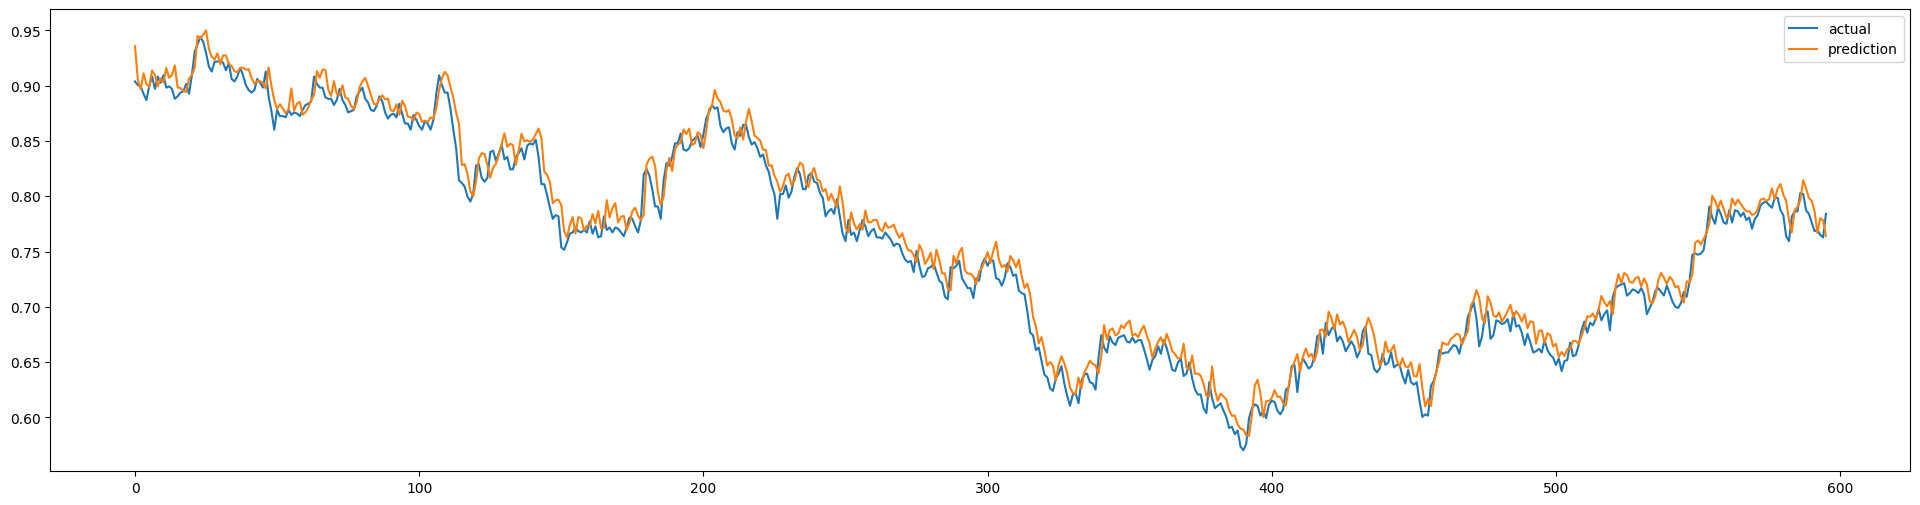

In [49]:
plt.figure(figsize=(24, 6))
plt.plot(y_test, label='actual')
plt.plot(model.predict(X_test), label='prediction')
plt.legend()
plt.show()

최근 20일간의 데이터를 이용하여 현재일 대비 다음날의 종가 변화율을 예측합니다.



In [54]:
test_df2 = test_df[:-3]
test_df2 

,Date,Open,High,Low,Close,Volume,Change
5980,2023-07-25,0.791418,0.743514,0.779350,0.771746,0.214480,-0.005682
5981,2023-07-26,0.781270,0.728798,0.775938,0.762795,0.143721,-0.002857
5982,2023-07-27,0.772251,0.730900,0.778213,0.777340,0.135563,0.027221
5983,2023-07-28,0.779015,0.728798,0.775938,0.763913,0.152582,-0.015342
5984,2023-07-31,0.769996,0.720389,0.761152,0.751606,0.221865,-0.011331
5985,2023-08-01,0.757594,0.708826,0.757740,0.746011,0.136239,0.018625
5986,2023-08-02,0.745191,0.709877,0.750916,0.748249,0.120817,-0.016878
5987,2023-08-03,0.759848,0.708826,0.748641,0.738179,0.161776,-0.015737
5988,2023-08-04,0.748574,0.714081,0.754328,0.752725,0.190532,-0.007267
5989,2023-08-07,0.751956,0.702519,0.753190,0.742654,0.112603,0.002928


In [56]:
pred_value = model.predict(test_df2[train_cols].values.reshape(1, 17, len(train_cols)))

change_value = (test_df.Close.iloc[-1] / pred_value)[0][0]
if change_value > 0:
    print(f"다음 종가는 {abs(change_value):.4f}% 상승")
elif change_value < 0:
    print(f"다음 종가는 {abs(change_value):.4f}% 하락")
else:
    print("다음 종가는 변화 없음")


1/1 [==============================] - 1s 1s/step
다음 종가는 변화 없음


## 2. 분류 모델 적용을 위한 모터 센서 시계열 데이터셋 변환
---

데이터셋은 모터의 여러 측정치를 기록한 데이터와 모터 ID 별로 고장 여부를 알려주는 라벨 데이터로 이루어져 있습니다.

모터의 상태를 알아내기 위해 센서를 통해 기록한 데이터는 아래와 같습니다. 참고로 각 실험마다 정상 모터와 측정 대상이 되는 모터를 같이 연결해놓고 실험을 하였습니다.

각 측정 대상 모터 ID 마다 측정을 수행한 시간 간격이 모두 다릅니다.

**motor_signals.csv column info**
| 컬럼 | 설명 |
| --- | --- |
| bearing_1_id | 정상 모터의 ID. 항상 0입니다. |
| bearing_2_id | 측정 대상 모터의 ID |
| timestamp | 기록 시각 |
| a1_x, a1_y, a1_z | 정상 모터의 x, y, z축 가속도 |
| a2_x, a2_y, a2_z | 측정 대상 모터의 x, y, z축 가속도 |
| rpm | 두 모터의 분당 회전속도 |
| hz | 두 모터의 초당 회전속도 |
| W | 측정 대상 모터의 소모전력 |

**motor_classes.csv column info**
| 컬럼 | 설명 |
| --- | --- |
| bearing_id | 측정 대상 모터의 ID |
| status | 고장 여부 |

---

###  라이브러리 로드

In [61]:
from operator import add
from functools import reduce

from tqdm import tqdm
import os

일정한 시간대별로 집계를 적용하여 피봇테이블 형식으로 데이터를 변환합니다.

csv파일을 dataframe 형태로 저장합니다.

pandas를 사용하여 dataframe 형태로 motor_signals를 불러와 `signals_df`에 저장합니다.

pandas를 사용하여 dataframe 형태로 motor_classes를 불러와 `classes_df`에 저장합니다. 불러 올 때 parameter는 `sep=";"`로 설정합니다.

In [62]:
# motor_signals.csv 불러오기
signals_df = pd.read_csv("./data/motor_signals.csv")

# motor_classes.csv 불러오기
classes_df = pd.read_csv("./data/motor_classes.csv", sep=";")

In [64]:
signals_df.tail()

,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,hz,w
6710695,0,72,32.098333,-0.367713,0.149706,0.465916,-0.469243,0.194450,0.553945,178.748759,2.979146,0.019412
6710696,0,72,32.098667,-0.463909,0.338975,0.561948,-0.469243,0.194450,0.354653,178.748759,2.979146,0.032027
6710697,0,72,32.099000,0.017072,0.433610,0.369884,-0.563647,-0.093886,0.155361,178.748759,2.979146,0.012211
6710698,0,72,32.099333,0.209465,0.244341,0.273852,-0.374838,0.194450,0.155361,178.748759,2.979146,0.000764
6710699,0,72,32.099667,0.498054,0.244341,0.177821,-0.186030,0.290562,-0.243222,178.748759,2.979146,0.002794


`signals_df`의 `timestamp`를 데이터 분석 및 전처리 시에 편의성을 높이기 위해 round를 이용하여 초단위로 반올림합니다.

In [65]:
signals_df.timestamp = signals_df.timestamp.round(1)

In [69]:
signals_df[500:]

,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,hz,w
500,0,1,0.2,-0.367713,0.055072,-0.110275,0.191588,0.002226,0.255007,0.000000,0.000000,0.000070
501,0,1,0.2,0.113269,0.055072,-0.398371,0.191588,0.002226,0.255007,0.000000,0.000000,0.000697
502,0,1,0.2,-0.367713,0.055072,0.177821,0.380396,0.098338,0.055715,0.000000,0.000000,0.000520
503,0,1,0.2,0.113269,0.244341,-0.302339,-0.091625,0.002226,0.354653,0.000000,0.000000,0.000093
504,0,1,0.2,-0.271517,-0.228832,-0.110275,0.285992,0.002226,-0.043930,0.000000,0.000000,0.000243
...,...,...,...,...,...,...,...,...,...,...,...,...
6710695,0,72,32.1,-0.367713,0.149706,0.465916,-0.469243,0.194450,0.553945,178.748759,2.979146,0.019412
6710696,0,72,32.1,-0.463909,0.338975,0.561948,-0.469243,0.194450,0.354653,178.748759,2.979146,0.032027
6710697,0,72,32.1,0.017072,0.433610,0.369884,-0.563647,-0.093886,0.155361,178.748759,2.979146,0.012211
6710698,0,72,32.1,0.209465,0.244341,0.273852,-0.374838,0.194450,0.155361,178.748759,2.979146,0.000764


`bearing_2_id`, `timstamp의` group별로 mean, std, min, max, 25%, 50%, 75% 값을 구합니다.

하나의 `bearing_2_id`는 여러개의 `timestamp`를 갖고 있으며, 하나의 timestamp는 여러 row를 가지고 있습니다.

`timestamp`별로 row의 통계치를 추출하여 `timestamp`별로 하나의 row만을 가지도록 합니다.

**주의!! 15분 걸릴 수 있음**

In [72]:
signals_df.timestamp.unique()

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

In [70]:
# 통계데이터를 담을 values와 key를 담을 keys를 list로 선언합니다.
values = []
keys = []

# for를 이용하여 signals_df의 bearing_2_id 컬럼에서 unique한 값만 가져와 id에 저장합니다.
for id in tqdm(signals_df.bearing_2_id.unique()):
    # for를 이용하여 signals_df의 bearing_2_id이 id와 일치하는 timestamp 컬럼에서 unique한 값만 가져와 t에 저장합니다.
    for t in signals_df[signals_df.bearing_2_id==id].timestamp.unique():
        # [id, t]를 keys에 append 합니다.
        keys.append([id, t])
        # signals_df에서 bearing_2_id와 id, timetamp와 t가 동시에 일치하는 dataframe만 가져와 저장합니다.
        value_df = signals_df[(signals_df.bearing_2_id==id) & (signals_df.timestamp==t)]
        # 가져온 dataframe 중 bearing_1_id, bearing_2_id, timestamp은 제외합니다.
        value_df = value_df.iloc[:, 3:]
        # describe를 이용하여 기본적인 통계값을 구합니다. 이 때 count 값은 제외합니다.
        value_df = value_df.describe()[1:]
        # value_df를 1개의 row로 변환합니다.
        value_df = value_df.stack().to_frame().T
        # value_df를 values에 append 합니다.
        values.append(value_df)

100%|██████████| 72/72 [14:22<00:00, 11.98s/it]


`values`를 pd.concat하여 `values_df`에 저장합니다.

In [71]:
values_df = pd.concat(values)
values_df

mean                                                                \
        a1_x      a1_y      a1_z      a2_x      a2_y      a2_z         rpm   
0  -0.096325  0.016842 -0.112183  0.144073  0.048054  0.199575    0.000000   
0  -0.091028  0.016458 -0.105779  0.151489  0.038228  0.192020    0.000000   
0  -0.092547  0.013571 -0.110275  0.151442  0.037989  0.193432    0.000000   
0  -0.083628  0.012977 -0.101925  0.148332  0.028263  0.190687    0.000000   
0  -0.088712  0.020488 -0.121761  0.137642  0.031922  0.187804    0.000000   
..       ...       ...       ...       ...       ...       ...         ...   
0  -0.057961  0.079992  0.159254 -0.147324  0.142229  0.127461  184.277507   
0  -0.071108  0.083462  0.110918 -0.131905  0.141909  0.147058  182.555781   
0  -0.056358  0.100181  0.124363 -0.137883  0.123327  0.074980  182.555781   
0  -0.071428  0.077153  0.138768 -0.132219  0.134540  0.191234  181.933967   
0  -0.059885  0.088509  0.158614 -0.135681  0.120764  0.113510  178.748759   

                             std  ...       75%       max                      \
          hz         w      a1_x  ...         w      a1_x      a1_y      a1_z   
0   0.000000  0.000320  0.172827  ...  0.000520  0.209465  0.528244  0.369884   
0   0.000000  0.000346  0.167028  ...  0.000520  0.305661  0.528244  0.273852   
0   0.000000  0.000319  0.169019  ...  0.000520  0.209465  0.433610  0.273852   
0   0.000000  0.000346  0.167856  ...  0.000520  0.305661  0.338975  0.273852   
0   0.000000  0.000358  0.170732  ...  0.000520  0.401857  0.433610  0.273852   
..       ...       ...       ...  ...       ...       ...       ...       ...   
0   3.071292  0.015498  0.260193  ...  0.017456  0.498054  0.622879  0.946076   
0   3.042596  0.010569  0.289334  ...  0.017456  0.690446  0.717513  0.850044   
0   3.042596  0.012006  0.285635  ...  0.017456  0.786643  1.001417  0.754012   
0   3.032233  0.012499  0.305219  ...  0.020429  0.786643  0.812148  0.754012   
0   2.979146  0.011157  0.288912  ...  0.017221  0.594250  0.622879  0.754012   

                                                                  
        a2_x      a2_y      a2_z         rpm        hz         w  
0   0.474800  0.290562  0.553945    0.000000  0.000000  0.000901  
0   0.474800  0.386674  0.553945    0.000000  0.000000  0.000976  
0   0.380396  0.386674  0.553945    0.000000  0.000000  0.000976  
0   0.474800  0.386674  0.553945    0.000000  0.000000  0.002084  
0   0.474800  0.290562  0.553945    0.000000  0.000000  0.001130  
..       ...       ...       ...         ...       ...       ...  
0   0.663609  0.771121  1.948987  186.142709  3.102378  1.210170  
0   0.852418  0.867233  1.749695  182.555781  3.042596  0.237735  
0   0.758013  0.963345  1.749695  182.555781  3.042596  0.099774  
0   0.852418  1.347793  4.141196  182.555781  3.042596  0.106719  
0   0.663609  0.771121  2.048633  178.748759  2.979146  0.084478  

[22441 rows x 63 columns]

컬럼명을 agg_col 형태로 변환합니다. 예) mean_a1_x, mean_a1_y ... max_hz, max_w

list comprehension을 이용하여 `values_df.columns`를 agg, col로 가져 온 후 agg_col 형태로 `values_df.columns`에 다시 저장합니다.

In [73]:
values_df.columns = [f"{agg}_{col}" for agg, col in values_df.columns]
values_df.reset_index(drop=True, inplace=True)

In [74]:
values_df

,mean_a1_x,mean_a1_y,mean_a1_z,mean_a2_x,mean_a2_y,mean_a2_z,mean_rpm,mean_hz,mean_w,std_a1_x,...,75%_w,max_a1_x,max_a1_y,max_a1_z,max_a2_x,max_a2_y,max_a2_z,max_rpm,max_hz,max_w
0,-0.096325,0.016842,-0.112183,0.144073,0.048054,0.199575,0.000000,0.000000,0.000320,0.172827,...,0.000520,0.209465,0.528244,0.369884,0.474800,0.290562,0.553945,0.000000,0.000000,0.000901
1,-0.091028,0.016458,-0.105779,0.151489,0.038228,0.192020,0.000000,0.000000,0.000346,0.167028,...,0.000520,0.305661,0.528244,0.273852,0.474800,0.386674,0.553945,0.000000,0.000000,0.000976
2,-0.092547,0.013571,-0.110275,0.151442,0.037989,0.193432,0.000000,0.000000,0.000319,0.169019,...,0.000520,0.209465,0.433610,0.273852,0.380396,0.386674,0.553945,0.000000,0.000000,0.000976
3,-0.083628,0.012977,-0.101925,0.148332,0.028263,0.190687,0.000000,0.000000,0.000346,0.167856,...,0.000520,0.305661,0.338975,0.273852,0.474800,0.386674,0.553945,0.000000,0.000000,0.002084
4,-0.088712,0.020488,-0.121761,0.137642,0.031922,0.187804,0.000000,0.000000,0.000358,0.170732,...,0.000520,0.401857,0.433610,0.273852,0.474800,0.290562,0.553945,0.000000,0.000000,0.001130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22436,-0.057961,0.079992,0.159254,-0.147324,0.142229,0.127461,184.277507,3.071292,0.015498,0.260193,...,0.017456,0.498054,0.622879,0.946076,0.663609,0.771121,1.948987,186.142709,3.102378,1.210170
22437,-0.071108,0.083462,0.110918,-0.131905,0.141909,0.147058,182.555781,3.042596,0.010569,0.289334,...,0.017456,0.690446,0.717513,0.850044,0.852418,0.867233,1.749695,182.555781,3.042596,0.237735
22438,-0.056358,0.100181,0.124363,-0.137883,0.123327,0.074980,182.555781,3.042596,0.012006,0.285635,...,0.017456,0.786643,1.001417,0.754012,0.758013,0.963345,1.749695,182.555781,3.042596,0.099774
22439,-0.071428,0.077153,0.138768,-0.132219,0.134540,0.191234,181.933967,3.032233,0.012499,0.305219,...,0.020429,0.786643,0.812148,0.754012,0.852418,1.347793,4.141196,182.555781,3.042596,0.106719


In [76]:
values_df.columns

Index(['mean_a1_x', 'mean_a1_y', 'mean_a1_z', 'mean_a2_x', 'mean_a2_y',
       'mean_a2_z', 'mean_rpm', 'mean_hz', 'mean_w', 'std_a1_x', 'std_a1_y',
       'std_a1_z', 'std_a2_x', 'std_a2_y', 'std_a2_z', 'std_rpm', 'std_hz',
       'std_w', 'min_a1_x', 'min_a1_y', 'min_a1_z', 'min_a2_x', 'min_a2_y',
       'min_a2_z', 'min_rpm', 'min_hz', 'min_w', '25%_a1_x', '25%_a1_y',
       '25%_a1_z', '25%_a2_x', '25%_a2_y', '25%_a2_z', '25%_rpm', '25%_hz',
       '25%_w', '50%_a1_x', '50%_a1_y', '50%_a1_z', '50%_a2_x', '50%_a2_y',
       '50%_a2_z', '50%_rpm', '50%_hz', '50%_w', '75%_a1_x', '75%_a1_y',
       '75%_a1_z', '75%_a2_x', '75%_a2_y', '75%_a2_z', '75%_rpm', '75%_hz',
       '75%_w', 'max_a1_x', 'max_a1_y', 'max_a1_z', 'max_a2_x', 'max_a2_y',
       'max_a2_z', 'max_rpm', 'max_hz', 'max_w'],
      dtype='object')

`keys`를 DataFrame으로 변환하여 `keys_df`에 저장합니다.

In [77]:
keys_df = pd.DataFrame(keys, columns=signals_df.columns[1:3])
keys_df

,bearing_2_id,timestamp
0,1,0.0
1,1,0.1
2,1,0.2
3,1,0.3
4,1,0.4
...,...,...
22436,72,31.7
22437,72,31.8
22438,72,31.9
22439,72,32.0


`keys_df`와 `values_df`를 concat하여 `bearing_2_id`, `timestamp` 별로 통계값을 가진 데이터프레임을 완성합니다.

In [78]:
seq_df = pd.concat([keys_df, values_df], axis=1)
seq_df

,bearing_2_id,timestamp,mean_a1_x,mean_a1_y,mean_a1_z,mean_a2_x,mean_a2_y,mean_a2_z,mean_rpm,mean_hz,...,75%_w,max_a1_x,max_a1_y,max_a1_z,max_a2_x,max_a2_y,max_a2_z,max_rpm,max_hz,max_w
0,1,0.0,-0.096325,0.016842,-0.112183,0.144073,0.048054,0.199575,0.000000,0.000000,...,0.000520,0.209465,0.528244,0.369884,0.474800,0.290562,0.553945,0.000000,0.000000,0.000901
1,1,0.1,-0.091028,0.016458,-0.105779,0.151489,0.038228,0.192020,0.000000,0.000000,...,0.000520,0.305661,0.528244,0.273852,0.474800,0.386674,0.553945,0.000000,0.000000,0.000976
2,1,0.2,-0.092547,0.013571,-0.110275,0.151442,0.037989,0.193432,0.000000,0.000000,...,0.000520,0.209465,0.433610,0.273852,0.380396,0.386674,0.553945,0.000000,0.000000,0.000976
3,1,0.3,-0.083628,0.012977,-0.101925,0.148332,0.028263,0.190687,0.000000,0.000000,...,0.000520,0.305661,0.338975,0.273852,0.474800,0.386674,0.553945,0.000000,0.000000,0.002084
4,1,0.4,-0.088712,0.020488,-0.121761,0.137642,0.031922,0.187804,0.000000,0.000000,...,0.000520,0.401857,0.433610,0.273852,0.474800,0.290562,0.553945,0.000000,0.000000,0.001130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22436,72,31.7,-0.057961,0.079992,0.159254,-0.147324,0.142229,0.127461,184.277507,3.071292,...,0.017456,0.498054,0.622879,0.946076,0.663609,0.771121,1.948987,186.142709,3.102378,1.210170
22437,72,31.8,-0.071108,0.083462,0.110918,-0.131905,0.141909,0.147058,182.555781,3.042596,...,0.017456,0.690446,0.717513,0.850044,0.852418,0.867233,1.749695,182.555781,3.042596,0.237735
22438,72,31.9,-0.056358,0.100181,0.124363,-0.137883,0.123327,0.074980,182.555781,3.042596,...,0.017456,0.786643,1.001417,0.754012,0.758013,0.963345,1.749695,182.555781,3.042596,0.099774
22439,72,32.0,-0.071428,0.077153,0.138768,-0.132219,0.134540,0.191234,181.933967,3.032233,...,0.020429,0.786643,0.812148,0.754012,0.852418,1.347793,4.141196,182.555781,3.042596,0.106719


`seq_df`와 `classes_df`를 merge하여 `result_df`에 저장합니다.

In [68]:
classes_df

,bearing_id,status
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
68,68,1
69,69,1
70,70,1
71,71,1


In [79]:
result_df = seq_df.merge(classes_df, left_on="bearing_2_id", right_on="bearing_id").drop(columns=["bearing_id"])
result_df

,bearing_2_id,timestamp,mean_a1_x,mean_a1_y,mean_a1_z,mean_a2_x,mean_a2_y,mean_a2_z,mean_rpm,mean_hz,...,max_a1_x,max_a1_y,max_a1_z,max_a2_x,max_a2_y,max_a2_z,max_rpm,max_hz,max_w,status
0,1,0.0,-0.096325,0.016842,-0.112183,0.144073,0.048054,0.199575,0.000000,0.000000,...,0.209465,0.528244,0.369884,0.474800,0.290562,0.553945,0.000000,0.000000,0.000901,0
1,1,0.1,-0.091028,0.016458,-0.105779,0.151489,0.038228,0.192020,0.000000,0.000000,...,0.305661,0.528244,0.273852,0.474800,0.386674,0.553945,0.000000,0.000000,0.000976,0
2,1,0.2,-0.092547,0.013571,-0.110275,0.151442,0.037989,0.193432,0.000000,0.000000,...,0.209465,0.433610,0.273852,0.380396,0.386674,0.553945,0.000000,0.000000,0.000976,0
3,1,0.3,-0.083628,0.012977,-0.101925,0.148332,0.028263,0.190687,0.000000,0.000000,...,0.305661,0.338975,0.273852,0.474800,0.386674,0.553945,0.000000,0.000000,0.002084,0
4,1,0.4,-0.088712,0.020488,-0.121761,0.137642,0.031922,0.187804,0.000000,0.000000,...,0.401857,0.433610,0.273852,0.474800,0.290562,0.553945,0.000000,0.000000,0.001130,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22436,72,31.7,-0.057961,0.079992,0.159254,-0.147324,0.142229,0.127461,184.277507,3.071292,...,0.498054,0.622879,0.946076,0.663609,0.771121,1.948987,186.142709,3.102378,1.210170,1
22437,72,31.8,-0.071108,0.083462,0.110918,-0.131905,0.141909,0.147058,182.555781,3.042596,...,0.690446,0.717513,0.850044,0.852418,0.867233,1.749695,182.555781,3.042596,0.237735,1
22438,72,31.9,-0.056358,0.100181,0.124363,-0.137883,0.123327,0.074980,182.555781,3.042596,...,0.786643,1.001417,0.754012,0.758013,0.963345,1.749695,182.555781,3.042596,0.099774,1
22439,72,32.0,-0.071428,0.077153,0.138768,-0.132219,0.134540,0.191234,181.933967,3.032233,...,0.786643,0.812148,0.754012,0.852418,1.347793,4.141196,182.555781,3.042596,0.106719,1


피봇테이블 형식의 데이터에 슬라이딩 윈도우를 적용하여 시계열 데이터로 변환합니다.


In [80]:
def vectorized_stride_v2(array, clearing_time_index, max_time, sub_window_size,
                         stride_size):
    # 9, 10 이므로 1부터 start
    start = clearing_time_index + 1 - sub_window_size + 1 
    
    sub_windows = (
        # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:sliding windows에서 보는 10개 값
        start + 
        np.expand_dims(np.arange(sub_window_size), 0) + 
        # max_time+1이 넘어가면 뒤에 9개 미만으로 남아서 sliding windows를 만들 수 없음
        # start(=1)과 두 배열을 합치, bradcasting으로 [[1~10], [2~11], [3~12]..]으로 가능한 모든 sliding window가 나옴
        np.expand_dims(np.arange(max_time + 1, step=stride_size), 0).T
    )
    return array[sub_windows]

슬라이딩 윈도우를 적용한 데이터셋을 만듭니다.

In [81]:
# clearing_time_index=9, sub_window_size=10, stride_size=1을 선언합니다.
clearing_time_index = 9
sub_window_size = 10
stride_size = 1

# keys, te_data를 list로 선언합니다.
keys = []
ts_data = []

# for를 이용하여 signals_df.bearing_2_id의 unique 한 값들을 id에 담습니다.
for id in signals_df.bearing_2_id.unique():
    # result_df에서 bearing_2_id가 id와 일치하는 DataFrame만 df에 저장합니다.
    df = result_df[result_df.bearing_2_id==id]
    # df의 길이 - (sub_window_size + stride_size)를 max_time에 저장합니다.
    max_time = len(df) - (sub_window_size + stride_size)
    # df.iloc[:, 2:].values, clearing_time_index, max_time, sub_window_size, stride_size를 
    # vectorized_stride_v2에 넘겨주어 반환 된 값을 ts_data에 append 합니다.
    ts_data.append(vectorized_stride_v2(df.iloc[:, 2:].values, clearing_time_index, max_time, sub_window_size, stride_size))
    # keys에 [id] * len(ts_data[-1]) 를 append 합니다.
    keys.append([id] * len(ts_data[-1]))

In [95]:
result_df[result_df['bearing_2_id'] == 2]['timestamp'].nunique()

292

In [94]:
result_df[result_df['bearing_2_id'] == 1]['timestamp'].nunique()

285

In [87]:
ts_data[0].shape

(275, 10, 64)

In [88]:
ts_data[1].shape

(282, 10, 64)

In [85]:
len(ts_data)

72

`ts_data`를 concatenate하여 완전한 timeseries 형태로 변환합니다.

In [96]:
ts_data = np.concatenate(ts_data)
ts_data.shape

(21721, 10, 64)

ts_data와 매칭돠는 `key_label_df` 구현합니다.

In [98]:
keys_df = pd.DataFrame(reduce(add ,keys), columns=["bearing_2_id"])

# keys_df와 classes_df를 이용하여 ts_data와 매칭되는 bearing_2_id, status 컬럼을 가진 DataFrame을 key_label_df에 저장합니다.
key_label_df = keys_df.merge(classes_df, left_on="bearing_2_id", right_on="bearing_id", how="left").drop(columns=["bearing_id"])
key_label_df

,bearing_2_id,status
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
21716,72,1
21717,72,1
21718,72,1
21719,72,1


데이터 셋을 분할합니다.

데이터 길이 중 70%에 해당하는 수를 `train_szie`에 저장합니다.

In [100]:
# train으로 사용 할 size를 지정합니다.
train_size = int(len(ts_data)*0.7)
train_size

15204

`ts_data`의 length 만큼의 np.arange를 `idx`에 저장 후 shuffle 합니다.

In [101]:
# ts_data의 lenth 만큼의 np.arange를 idx에 저장합니다.
idx = np.arange(len(ts_data))
# idx를 random하게 shuffle합니다. 
np.random.shuffle(idx)

`idx`와 `train_size`를 이용하여 train, test로 쓰일 `idx`를 나누어 각각 `train_idx`, `test_idx`에 저장합니다.

In [102]:
train_idx = idx[:train_size]
test_idx = idx[train_size:]

In [103]:
train_idx

array([ 7468, 13874, 12733, ...,  5609, 21025, 12450])

`ts_data`, `key_label_df`, `train_idx`, `test_idx`를 이용하여 `X_train`, `X_test`, `y_train`, `Y_test`를 만듭니다.

In [104]:
X_train = ts_data[train_idx]
X_test = ts_data[test_idx]
y_train = key_label_df.status.values[train_idx]
y_test = key_label_df.status.values[test_idx]

X_train.shape

(15204, 10, 64)

## 3. tensorflow를 활용한 RNN 기반 모델을 모터 데이터에 적용
---

모델 학습 시 random_state를 고정적으로 사용하기 위해 random_state 변수 및 seed를 75로 설정합니다.

In [105]:
random_state = 75

np.random.seed(random_state)
tf.random.set_seed(random_state)

일전에 제작하였던 ML 모델 성능 평가 시 f1_score를 사용하였습니다.

이번엔 DL 모델 제작 및 성능 평가를 진행 할 예정이지만 tensorflow는 sklearn과 달리 f1_score metric을 제공하지 않습니다.

때문에 f1_score를 직접 구현하여 DL 모델에서 f1_score를 이용하여 성능평가 할 수 있도록 합니다.


In [113]:
def recall(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + backend.epsilon())

f1_score 계산 시 필요한 precision을 구현합니다.

In [114]:
def precision(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + backend.epsilon())

f1_score을 구현합니다.

In [115]:
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + backend.epsilon()))

시계열 데이터를 학습 할 `model`을 구현합니다.

In [108]:
# Sequential을 이용하여 RNN 기반 모델을 구현합니다.
model = Sequential([
    # layers.Bidirectional에 tf.keras.layers.LSTM를 파라미터로 넘겨 layer를 구성합니다. 
    #이 때 unit의 수는 데이터의 컬럼 수인 64로 지정합니다.
    layers.Bidirectional(layers.LSTM(64)),
    # layers.Dense를 구성합니다. 이 떄 unit 수는 64, activation은 relu로 지정합니다.
    layers.Dense(64, activation="relu"),
    # output layer의 역할인 layers.Dense를 구성합니다. 이 떄 unit 수는 1, activation은 sigmoid로 지정합니다.
    layers.Dense(1, activation="sigmoid")
])

`model`을 컴파일합니다.

In [116]:
# model을 compile 합니다.
model.compile(
    # loss는 tf.keras.losses.BinaryCrossentropy()로 지정합니다.
    loss=tf.keras.losses.BinaryCrossentropy(),
    # optimizer은 tf.keras.optimizers.Adam(1e-4)로 지정합니다.
    optimizer=tf.keras.optimizers.Adam(1e-4),
    # metrics는 accuracy와 위에서 선언한 f1_score, precision, recall로 지정합니다.
    metrics=["accuracy", f1_score, precision, recall]
)

모델을 학습합니다.

callbacks.EarlyStopping를 이용하여 학습 중 5 epoch 이내에 f1_score가 상승하지 않을 시 학습을 멈추도록 합니다.

In [119]:
cbs = [callbacks.EarlyStopping(
        # early stopping의 기준을 f1_score로 지정합니다.
        monitor="f1_score",
        # f1_score는 0 <= 1의 값을 가지며 높을 수록 성능이 좋으니 mode를 max로 지정합니다.
        mode="max",
        # patience는 5로 지정하여 5번 이내에 f1_score가 높아지지 않을 경우 early stopping 하도록 합니다.
        patience = 5
    )]

In [123]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,369
Trainable params: 74,369
Non-trainable params: 0
_________________________________________________________________


`model`을 학습합니다. callbacks은 위에서 선언한 `cbs`를 사용합니다.

**주의!! 4분 걸릴 수 있음**

In [120]:
# model을 학습합니다.
hist = model.fit(
    # 학습 데이터를 넣어줍니다.
    X_train,
    # 라벨 데이터를 넣어줍니다.
    y_train,
    # epochs를 20으로 지정합니다.
    epochs=30,
    # batch_size는 20으로 지정합니다.
    batch_size=20,
    # callbacks으로 callbacks.EarlyStopping을 선언합니다.
    callbacks = cbs
)

Epoch 1/30
761/761 [==============================] - 9s 6ms/step - loss: 0.4569 - accuracy: 0.8080 - f1_score: 0.0146 - precision: 0.0155 - recall: 0.0356
Epoch 2/30
761/761 [==============================] - 5s 6ms/step - loss: 0.4029 - accuracy: 0.8318 - f1_score: 0.0285 - precision: 0.0670 - recall: 0.0187
Epoch 3/30
761/761 [==============================] - 5s 6ms/step - loss: 0.3599 - accuracy: 0.8367 - f1_score: 0.0726 - precision: 0.1553 - recall: 0.0509
Epoch 4/30
761/761 [==============================] - 5s 6ms/step - loss: 0.3215 - accuracy: 0.8574 - f1_score: 0.2691 - precision: 0.4288 - recall: 0.2206
Epoch 5/30
761/761 [==============================] - 5s 6ms/step - loss: 0.2870 - accuracy: 0.8812 - f1_score: 0.4444 - precision: 0.6556 - recall: 0.3817
Epoch 6/30
761/761 [==============================] - 5s 6ms/step - loss: 0.2559 - accuracy: 0.8998 - f1_score: 0.5608 - precision: 0.7292 - recall: 0.5023
Epoch 7/30
761/761 [==============================] - 5s 6ms/ste

모델 성능을 평가합니다.

`model`의 성능을 출력하는 함수를 구현합니다.

In [121]:
def dl_performance_printer(model_name, model, X_test,  y_test):
    # model의 evaluate를 사용하여 loss, accuracy, f1_score, precision, recall를 산출합니다.
    loss, accuracy, f1, precision, recall = model.evaluate(X_test,  y_test)

    print(f"{model_name}", end="\t")
    print(f"accuracy: {accuracy:.4f}", end="    ")
    print(f"f1_score: {f1:.4f}", end="    ")
    print(f"recall: {recall:.4f}", end="    ")
    print(f"precision: {precision:.4f}", end="    ")
    print(f"loss: {loss:.4f}")

`X_test`, `y_test`를 이용하여 학습이 완료된 모델 성능을 평가합니다.

In [122]:
dl_performance_printer("lstm", model, X_test,  y_test)

204/204 [==============================] - 2s 3ms/step - loss: 0.0183 - accuracy: 0.9948 - f1_score: 0.9780 - precision: 0.9656 - recall: 0.9951
lstm	accuracy: 0.9948    f1_score: 0.9780    recall: 0.9951    precision: 0.9656    loss: 0.0183


GRU를 이용한 모델을 생성합니다.

In [124]:
gru_model = Sequential([
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

GRU 모델을 컴파일 합니다.

In [125]:
gru_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy", f1_score, precision, recall]
)

GRU 모델을 학습하고 성능을 평가합니다.

**주의!! 5분 걸릴 수 있음**

In [126]:
gru_hist = gru_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=20,
    callbacks = cbs
)

dl_performance_printer("gru", gru_model, X_test,  y_test)

Epoch 1/20
761/761 [==============================] - 9s 6ms/step - loss: 0.4845 - accuracy: 0.7991 - f1_score: 0.0194 - precision: 0.0195 - recall: 0.0479
Epoch 2/20
761/761 [==============================] - 5s 6ms/step - loss: 0.4341 - accuracy: 0.8310 - f1_score: 0.0221 - precision: 0.0512 - recall: 0.0146
Epoch 3/20
761/761 [==============================] - 5s 6ms/step - loss: 0.4051 - accuracy: 0.8331 - f1_score: 0.0397 - precision: 0.0913 - recall: 0.0267
Epoch 4/20
761/761 [==============================] - 5s 6ms/step - loss: 0.3633 - accuracy: 0.8355 - f1_score: 0.0615 - precision: 0.1270 - recall: 0.0438
Epoch 5/20
761/761 [==============================] - 5s 6ms/step - loss: 0.3290 - accuracy: 0.8550 - f1_score: 0.2411 - precision: 0.3998 - recall: 0.1938
Epoch 6/20
761/761 [==============================] - 5s 6ms/step - loss: 0.2964 - accuracy: 0.8779 - f1_score: 0.4310 - precision: 0.6207 - recall: 0.3709
Epoch 7/20
761/761 [==============================] - 5s 6ms/ste

In [129]:
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 128)              49920     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 58,241
Trainable params: 58,241
Non-trainable params: 0
_________________________________________________________________


RNN을 이용한 모델을 생성합니다.

In [130]:
rnn_model = Sequential([
    layers.Bidirectional(layers.SimpleRNN(64)),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

RNN 모델을 컴파일 합니다.

In [131]:
rnn_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy", f1_score, precision, recall]
)

RNN 모델을 학습하고 성능을 평가합니다.

**주의!! 20여분 걸릴 수 있음**

In [132]:
rnn_hist = rnn_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=20,
    callbacks = cbs
)

dl_performance_printer("rnn", rnn_model, X_test,  y_test)

Epoch 1/20
761/761 [==============================] - 5s 3ms/step - loss: 0.4516 - accuracy: 0.8189 - f1_score: 0.0090 - precision: 0.0120 - recall: 0.0162
Epoch 2/20
761/761 [==============================] - 2s 3ms/step - loss: 0.4109 - accuracy: 0.8304 - f1_score: 0.0207 - precision: 0.0453 - recall: 0.0140
Epoch 3/20
761/761 [==============================] - 2s 3ms/step - loss: 0.3805 - accuracy: 0.8359 - f1_score: 0.0915 - precision: 0.1812 - recall: 0.0676
Epoch 4/20
761/761 [==============================] - 2s 3ms/step - loss: 0.3519 - accuracy: 0.8507 - f1_score: 0.2398 - precision: 0.4036 - recall: 0.1905
Epoch 5/20
761/761 [==============================] - 2s 3ms/step - loss: 0.3227 - accuracy: 0.8681 - f1_score: 0.3709 - precision: 0.5709 - recall: 0.3083
Epoch 6/20
761/761 [==============================] - 2s 3ms/step - loss: 0.3025 - accuracy: 0.8779 - f1_score: 0.4514 - precision: 0.6338 - recall: 0.3970
Epoch 7/20
761/761 [==============================] - 2s 3ms/ste

In [133]:
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 128)              16512     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,833
Trainable params: 24,833
Non-trainable params: 0
_________________________________________________________________


# 4. 기존 분류 알고리즘과의 성능 비교하기
---

라이브러리 로드 및 데이터를 전처리 합니다.

In [134]:
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

ML 모델이 학습할 수 있는 형태로 데이터를 가공합니다.

In [135]:
# 데이터로 쓰일 수 있도록 result_df에서 ["bearing_2_id", "timestamp", "status"] 컬럼을 제외하여 X에 저장합니다.
X = result_df.drop(columns=["bearing_2_id", "timestamp", "status"])

# 라벨로 쓰일 수 있도록 result_df에서 status 컬럼만 y에 저장합니다.
y = result_df.status

# train_test_split을 이용하여 X_train, X_test, y_train, y_test을 저장합니다.
ml_X_train, ml_X_test, ml_y_train, ml_y_test = train_test_split(X, y, random_state=75)

LGBMClassifier, DecisionTreeClassifier, XGBClassifier를 리스트에 담아 `models`에 저장합니다.

In [136]:
# models list에 LGBMClassifier, DecisionTreeClassifier, XGBClassifier를 (model_name, model_method) 형태로 맞추어 저장합니다.
# model_method 호출 시 random_state parameter를 위에서 선언한 random_state로 설정합니다.
models = [
    ("lgbm", LGBMClassifier(random_state=random_state)),
    ("xgb", XGBClassifier(random_state=random_state)),
    ("tree", DecisionTreeClassifier(random_state=random_state))
]

모델의 성능을 측정하고 출력하는 `performance_printer`를 제작합니다.

In [137]:
def ml_performance_printer(model_name, y_test, y_pred):
    # 예측된 값인 y_pred와 실제 값인 y_test를 이용하여 accuracy, f1_score recall, precision을 산출합니다.
    # f1_score 산출 시 average parameter를 macro로 설정합니다.
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    print(f"{model_name}", end="\t")
    print(f"accuracy: {accuracy:.4f}", end="    ")
    print(f"f1_score: {f1:.4f}", end="    ")
    print(f"recall: {recall:.4f}", end="    ")
    print(f"precision: {precision:.4f}")

In [140]:
ml_X_train

,mean_a1_x,mean_a1_y,mean_a1_z,mean_a2_x,mean_a2_y,mean_a2_z,mean_rpm,mean_hz,mean_w,std_a1_x,...,75%_w,max_a1_x,max_a1_y,max_a1_z,max_a2_x,max_a2_y,max_a2_z,max_rpm,max_hz,max_w
15788,-0.149668,-0.023790,-0.068341,-0.668121,0.012478,0.057708,308.219178,5.136986,0.022101,0.334655,...,0.033661,0.979035,0.528244,0.850044,0.097183,0.578898,3.443675,308.219178,5.136986,0.241261
22436,-0.057961,0.079992,0.159254,-0.147324,0.142229,0.127461,184.277507,3.071292,0.015498,0.260193,...,0.017456,0.498054,0.622879,0.946076,0.663609,0.771121,1.948987,186.142709,3.102378,1.210170
11445,-0.267669,0.099550,0.100675,-0.459802,0.131016,0.309480,1484.514293,24.741905,0.423483,2.753910,...,0.566597,7.327991,7.341928,5.363544,8.876783,11.151205,5.835176,1487.603306,24.793388,0.828742
19394,-0.236127,0.038297,0.309182,-0.092888,-0.050812,0.213683,1488.115785,24.801930,0.783609,2.077860,...,0.892235,5.596457,4.124355,4.979416,5.383824,5.865051,6.731989,1500.000000,25.000000,1.157963
13973,-0.302197,0.006969,0.243224,-0.437252,0.030325,0.180521,1490.815738,24.846929,0.478919,1.755781,...,0.643629,5.788850,2.326300,6.611958,3.684547,5.384492,8.724907,1500.000000,25.000000,0.895638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8128,-0.184940,-0.019689,-0.153169,-0.669694,-0.074343,0.175623,279.937792,4.665630,0.026165,1.011993,...,0.041690,2.806765,4.597528,3.442905,4.439781,1.828352,9.123490,279.937792,4.665630,0.192168
14472,-0.151032,0.005711,0.109545,-0.614142,0.105363,0.035853,1260.426030,21.007100,0.628059,1.120385,...,0.875297,2.518176,2.420934,4.595288,3.684547,3.654478,9.023844,1267.605634,21.126761,1.376787
21969,-0.155825,0.147191,0.313733,-0.165330,0.191896,0.048101,1496.005052,24.933418,0.394923,1.742620,...,0.538476,4.634494,3.272645,5.555607,4.439781,3.846702,4.938363,1500.000000,25.000000,0.802710
2067,-0.232207,-0.028873,0.006495,-0.066848,0.096422,0.147416,1237.283374,20.621390,0.617041,1.839562,...,0.882051,4.057317,2.988741,7.092118,6.233463,6.249499,4.639426,1241.379310,20.689655,1.368345


for문을 이용하여 앞에서 `models`를 학습하고 성능을 평가합니다.

In [141]:
for model_name, ml_model in models:
    # X_train과 y_train을 이용하여 model을 학습합니다.
    ml_model.fit(ml_X_train, ml_y_train)

    # 학습된 모델에 test data를 넣어 예측된 값을 y_pred에 저장합니다.
    ml_y_pred = ml_model.predict(ml_X_test)

    #performance_printer를 이용하여 모델의 성능을 평가합니다.
    ml_performance_printer(model_name, ml_y_test, ml_y_pred)

[LightGBM] [Info] Number of positive: 2920, number of negative: 13910
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12612
[LightGBM] [Info] Number of data points in the train set: 16830, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.173500 -> initscore=-1.561024
[LightGBM] [Info] Start training from score -1.561024
lgbm	accuracy: 0.9886    f1_score: 0.9795    recall: 0.9587    precision: 0.9731
xgb	accuracy: 0.9907    f1_score: 0.9834    recall: 0.9672    precision: 0.9775
tree	accuracy: 0.9638    f1_score: 0.9357    recall: 0.8984    precision: 0.8881
